# 10. Feature generation (R)

In [1]:
library(tidyverse)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
sample_consolidated_file <- "../preprocessed_data/sample_consolidated_2019-09-02.feather"

## Read data

In [3]:
sample <- feather::read_feather(sample_consolidated_file)
glimpse(sample)

Observations: 1,425
Variables: 23
$ YEAR                  <dbl> 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008,…
$ COMMODITY             <chr> "crude", "crude", "hvl", "non-hvl", "hvl", "non…
$ OPERATOR_ID           <chr> "SemGroup (Group)", "BP (Group)", "BP (Group)",…
$ NAME                  <chr> "SemGroup (Group)", "BP (Group)", "BP (Group)",…
$ MILES                 <dbl> 119.000, 24.000, 359.000, 762.000, 881.000, 341…
$ AGE_UNKNOWN_MILES     <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ MILES_PRE_1940        <dbl> 22.000, 0.000, 0.000, 152.000, 0.000, 0.000, 0.…
$ MILES_1940            <dbl> 22.000, 0.000, 0.000, 2.000, 0.000, 763.000, 0.…
$ MILES_1950            <dbl> 146.00, 4.00, 0.00, 166.00, 0.70, 668.20, 368.2…
$ MILES_1960            <dbl> 10.000, 7.000, 186.000, 80.000, 38.200, 581.000…
$ MILES_1970            <dbl> 6.000, 5.000, 168.000, 700.000, 581.800, 0.000,…
$ MILES_1980            <dbl> 2.000, 3.000, 33.000, 29.000, 13.500, 0.000, 32…
$ MILES_1990      

## Alternatively: filter large changes

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 186 rows containing non-finite values (stat_bin).”

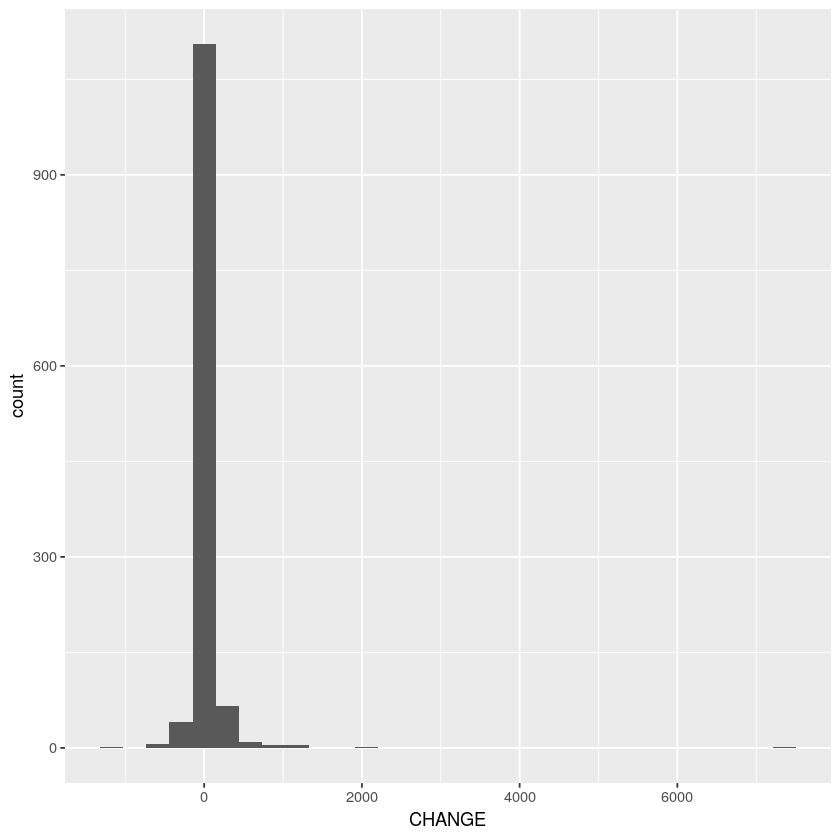

In [4]:
sample %>%
    ggplot(aes(x=CHANGE)) +
        geom_histogram()

In [5]:
nrow(sample)

[1] 1425

In [6]:
# sample <- subset(sample, abs(CHANGE) < 250)

In [7]:
sample <- subset(sample, COMMODITY %in% c("crude", "hvl", "non-hvl"))
table(sample$COMMODITY)


  crude     hvl non-hvl 
    485     423     449 

In [8]:
nrow(sample)

[1] 1357

## Alternatively: remove two years of change for oil pipelines we added

In [9]:
# sample <- subset(sample, YEAR >= 2010)

## 10.1 Three year moving average

Change

In [10]:
sample <- sample %>%
    group_by(OPERATOR_ID, COMMODITY) %>%
    arrange(desc(YEAR)) %>%
    mutate(change_1 = lead(CHANGE, 1), 
           change_2 = lead(CHANGE, 2), 
           change_3 = MILES - lead(MILES, 3)) %>%
    mutate(mean_change_3 = (change_3 / 3)) %>%
    mutate(sd_change_3 = sqrt((CHANGE - mean_change_3)^2 + (change_1 - mean_change_3)^2 + (change_2 - mean_change_3)^2 / 3))

Incidents

In [11]:
sample <- sample %>%
    group_by(OPERATOR_ID, COMMODITY) %>%
    arrange(desc(YEAR)) %>%
    mutate(miles_avg_3 = (MILES + lead(MILES, 1) + lead(MILES, 2)) / 3, 
           miles_1950_3 = (MILES_1950 + lead(MILES_1950, 1) + lead(MILES_1950, 2)) / 3,
           sign_inc_3 =  (SIGNIFICANT_INCIDENTS + lag(SIGNIFICANT_INCIDENTS, 1) + lag(SIGNIFICANT_INCIDENTS, 2)) / 3)

Incidents per mile

In [12]:
sample$inc_per_mile_3 <- sample$sign_inc_3 / sample$miles_avg_3

Percent of pipelines for each decade.

In [13]:
sample <- sample %>%
    mutate(age_miles = MILES_PRE_1940 + MILES_1940 + MILES_1950 + MILES_1960 + MILES_1970 + MILES_1980 +
                       MILES_1990 + MILES_2000 + MILES_2010)

In [14]:
sample <- sample %>%
    mutate(perc_pre_1940 = MILES_PRE_1940 / age_miles, 
           perc_1940 = MILES_1940 / age_miles,
           perc_1950 = MILES_1950 / age_miles,
           perc_1960 = MILES_1960 / age_miles,
           perc_1970 = MILES_1970 / age_miles,
           perc_1980 = MILES_1980 / age_miles,
           perc_1990 = MILES_1990 / age_miles,
           perc_2000 = MILES_2000 / age_miles, 
           perc_2010 = MILES_2010 / age_miles)

In [15]:
sample <- sample %>%
    group_by(OPERATOR_ID, COMMODITY) %>%
    arrange(desc(YEAR)) %>%
    mutate(avg_pre_1940 = (perc_pre_1940 + lag(perc_pre_1940) + lag(perc_pre_1940, 2)) /3, 
           avg_1940 = (perc_1940 + lag(perc_1940) + lag(perc_1940, 2)) / 3,
           avg_1950 = (perc_1950 + lag(perc_1950) + lag(perc_1950, 2)) / 3,
           avg_1960 = (perc_1960 + lag(perc_1960) + lag(perc_1960, 2)) / 3,
           avg_1970 = (perc_1970 + lag(perc_1970) + lag(perc_1970, 2)) / 3,
           avg_1980 = (perc_1980 + lag(perc_1980) + lag(perc_1980, 2)) / 3,
           avg_1990 = (perc_1990 + lag(perc_1990) + lag(perc_1990, 2)) / 3,
           avg_2000 = (perc_2000 + lag(perc_2000) + lag(perc_2000, 2)) / 3,
           avg_2010 = (perc_2010 + lag(perc_2010) + lag(perc_2010, 2)) / 3)

## 10.2 Incidents per mile

In [16]:
sample$INCIDENTS_MILE <- (sample$INCIDENTS / sample$MILES)
sample$SIGN_INC_MILE <- (sample$SIGNIFICANT_INCIDENTS / sample$MILES)

In [17]:
nrow(sample[!is.na(sample$sd_change_3), ])

[1] 891

## 10.3 Data types

In [18]:
sample$COMMODITY <- as.factor(sample$COMMODITY)
sample$OPERATOR_ID <- as.factor(sample$OPERATOR_ID)

## 10.4 past M&As

In [19]:
sample <- sample %>%
    group_by(OPERATOR_ID, COMMODITY) %>%
    arrange(desc(YEAR)) %>%
    mutate(M_A_3 = max(M_A, lead(M_A), lead(M_A, 2), na.rm=TRUE))
glimpse(sample)

Observations: 1,357
Variables: 54
Groups: OPERATOR_ID, COMMODITY [157]
$ YEAR                  <dbl> 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018,…
$ COMMODITY             <fct> crude, hvl, non-hvl, crude, hvl, non-hvl, crude…
$ OPERATOR_ID           <fct> Sunoco (Group), Sunoco (Group), Sunoco (Group),…
$ NAME                  <chr> "Sunoco (Group)", "Sunoco (Group)", "Sunoco (Gr…
$ MILES                 <dbl> 11349.160, 3241.490, 3973.070, 92.377, 24.609, …
$ AGE_UNKNOWN_MILES     <dbl> 1161.930, 235.050, 446.670, 0.000, 0.000, 0.000…
$ MILES_PRE_1940        <dbl> 807.21, 14.19, 50.76, 0.00, 0.00, 0.00, 1.70, 0…
$ MILES_1940            <dbl> 1501.050, 301.630, 387.790, 0.000, 0.000, 0.000…
$ MILES_1950            <dbl> 1557.090, 263.620, 268.660, 84.333, 0.000, 11.2…
$ MILES_1960            <dbl> 547.710, 140.240, 314.780, 40.250, 52.120, 2.84…
$ MILES_1970            <dbl> 297.900, 139.530, 677.410, 0.000, 0.000, 25.322…
$ MILES_1980            <dbl> 148.950, 19.290, 155.620, 18.8

## 10.5 Log transform etc.

In [20]:
sample$LOG_INCIDENTS_MILE <- log(sample$INCIDENTS_MILE)
sample$LOG_SIGN_INC_MILE <- log(sample$SIGN_INC_MILE)
sample$log_sd_change <- log(sample$sd_change_3)
sample$sd_change_sq <- (sample$sd_change_3)^2
sample$sd_change_pw_3 <- (sample$sd_change_3)^3
sample$one_over_sd_change <- (1 / sample$sd_change_3)

## 10.6 Interaction effects

In [21]:
sample$miles_x_change <- sample$MILES * sample$sd_change_3

## 10.7 Subsamples

In [22]:
sample_crude <- sample[(sample$COMMODITY == "crude"), ]
none_new <- subset(sample, COMMODITY %in% c("crude", "hvl", "non-hvl"))

## 10.7 Save

In [23]:
# testit::assert(nrow(subset(sample, YEAR == 2008)) > 0)
feather::write_feather(sample, paste0("../preprocessed_data/sample_features_", Sys.Date(), ".feather"))
haven::write_dta(sample, paste0("../stata_data/sample_features_", Sys.Date(), ".dta"))
feather::write_feather(sample_crude, paste0("../preprocessed_data/sample_features_crude_", Sys.Date(), ".feather"))
haven::write_dta(sample_crude, paste0("../stata_data/sample_features_crude_", Sys.Date(), ".dta"))
feather::write_feather(none_new, paste0("../preprocessed_data/sample_none_new_", Sys.Date(), ".feather"))
haven::write_dta(none_new, paste0("../stata_data/sample_none_new_", Sys.Date(), ".dta"))